In [43]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt


In [44]:
# Subclass nn.Module to make our model
class LinearRegressionModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        # Use nn.Linear() for creating the model parameters
        self.linear_layer = nn.Linear(in_features=1, 
                                      out_features=1)
    
    # Define the forward computation (input data x flows through nn.Linear())
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)


In [80]:
# Set the manual seed when creating the model (this isn't always needed but is used for demonstrative purposes, try commenting it out and seeing what happens)
torch.manual_seed(42)
model_1 = LinearRegressionModelV2()

if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("MPS device is available.")
else:
    print("MPS device is not available. Using CPU.")
    device = torch.device("cpu")
model_1.to(device) # the device variable was set above to be "cuda" if available or "cpu" if not
next(model_1.parameters()).device

MPS device is available.


device(type='mps', index=0)

In [81]:
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.01)

In [82]:
weight = 0.7
bias = 0.3

# Create data
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

# Create train/test split
train_split = int(0.8 * len(X)) # 80% of data used for training set, 20% for testing 
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

In [65]:
def plot_predictions(train_data=X_train, 
                     train_labels=y_train, 
                     test_data=X_test, 
                     test_labels=y_test, 
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")
  
  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  if predictions is not None:
    # Plot the predictions in red (predictions were made on the test data)
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 14});

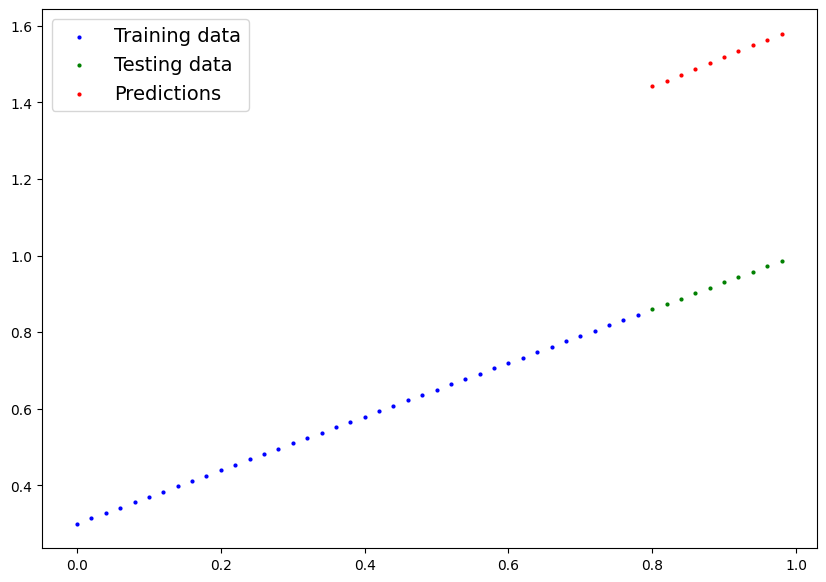

In [83]:

# Turn model into evaluation mode
model_1.eval()

# Make predictions on the test data
with torch.inference_mode():
    y_preds_initial = model_1(X_test)

plot_predictions(train_data=X_train.cpu(), train_labels=y_train.cpu(), 
                 test_data=X_test.cpu(), test_labels=y_test.cpu(), 
                 predictions=y_preds_initial.cpu())


In [84]:
torch.manual_seed(42)

# Set the number of epochs 
epochs = 1000 
epoch_count = []
losses = []
test_losses = []

for epoch in range(epochs):
    ### Training
    model_1.train() # train mode is on by default after construction

    # 1. Forward pass
    y_pred = model_1(X_train)

    # 2. Calculate loss
    loss = loss_fn(y_pred, y_train)

    # 3. Zero grad optimizer
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Step the optimizer
    optimizer.step()

    ### Testing
    model_1.eval() # put the model in evaluation mode for testing (inference)
    # 1. Forward pass
    with torch.inference_mode():
        test_pred = model_1(X_test)
    
        # 2. Calculate the loss
        test_loss = loss_fn(test_pred, y_test)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Train loss: {loss} | Test loss: {test_loss}")
        epoch_count.append(epoch)
        losses.append(loss.item())
        test_losses.append(test_loss.item())

Epoch: 0 | Train loss: 0.5551779270172119 | Test loss: 0.5739762783050537
Epoch: 100 | Train loss: 0.0062156799249351025 | Test loss: 0.014086711220443249
Epoch: 200 | Train loss: 0.0012645028764382005 | Test loss: 0.013801807537674904
Epoch: 300 | Train loss: 0.0012645028764382005 | Test loss: 0.013801807537674904
Epoch: 400 | Train loss: 0.0012645028764382005 | Test loss: 0.013801807537674904
Epoch: 500 | Train loss: 0.0012645028764382005 | Test loss: 0.013801807537674904
Epoch: 600 | Train loss: 0.0012645028764382005 | Test loss: 0.013801807537674904
Epoch: 700 | Train loss: 0.0012645028764382005 | Test loss: 0.013801807537674904
Epoch: 800 | Train loss: 0.0012645028764382005 | Test loss: 0.013801807537674904
Epoch: 900 | Train loss: 0.0012645028764382005 | Test loss: 0.013801807537674904


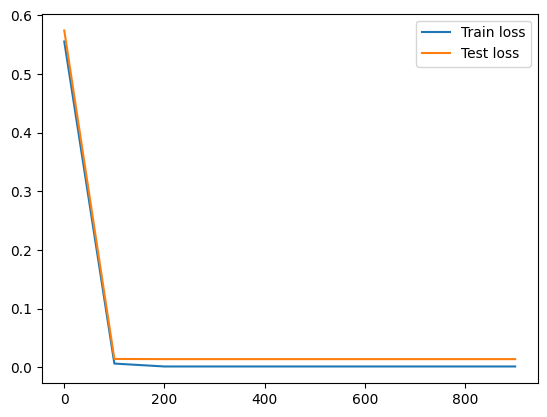

In [87]:
plt.plot(epoch_count, losses, label="Train loss")
plt.plot(epoch_count, test_losses, label="Test loss")
plt.legend()


In [69]:
# Turn model into evaluation mode
model_1.eval()

# Make predictions on the test data
with torch.inference_mode():
    y_preds = model_1(X_test)
y_preds

tensor([[0.8600],
        [0.8739],
        [0.8878],
        [0.9018],
        [0.9157],
        [0.9296],
        [0.9436],
        [0.9575],
        [0.9714],
        [0.9854]], device='mps:0')

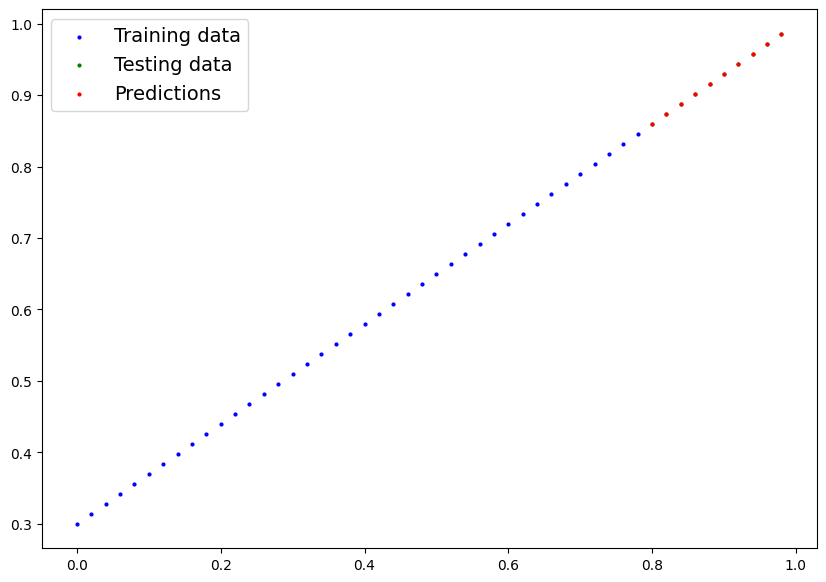

In [70]:
plot_predictions(train_data=X_train.cpu(), train_labels=y_train.cpu(), 
                 test_data=X_test.cpu(), test_labels=y_test.cpu(), 
                 predictions=y_preds.cpu())


In [40]:
from pathlib import Path

# 1. Create models directory 
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path 
MODEL_NAME = "01_pytorch_workflow_model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict 
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_1.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH) 

Saving model to: models/01_pytorch_workflow_model_1.pth


In [41]:
# Instantiate a fresh instance of LinearRegressionModelV2
loaded_model_1 = LinearRegressionModelV2()

# Load model state dict 
loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))

# Put model to target device (if your data is on GPU, model will have to be on GPU to make predictions)
loaded_model_1.to(device)

print(f"Loaded model:\n{loaded_model_1}")
print(f"Model on device:\n{next(loaded_model_1.parameters()).device}")

Loaded model:
LinearRegressionModelV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)
Model on device:
mps:0


/var/folders/59/c32_bthx48jd9m2ym5m3tnpw0000j7/T/ipykernel_53869/2631515358.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model_1.load_state_dict(torch.load(MOD

In [42]:
# Evaluate loaded model
loaded_model_1.eval()
with torch.inference_mode():
    loaded_model_1_preds = loaded_model_1(X_test)
y_preds == loaded_model_1_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='mps:0')

In [88]:
model_1.parameters()

<generator object Module.parameters at 0x168665700>